In [46]:
import os
import time

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from fidelity_analysis.mock_file_creator import shift_s2p_freq_axis_minimal
from floquet_analysis.transmon_floquet_simulator import TransmonFloquetSimulator
from floquet_analysis.transmon_resonator_fitter import TransmonResonatorFitter
from joblib import Parallel, delayed
from fidelity_analysis.pulse import RectangularReadoutPulse
from fidelity_analysis.fidelity_simulation import FidelitySimulation
from fidelity_analysis.utils import UnitConverter


In [47]:
#TEMPLATE_FILE = "template_0ghz_resonator_cut_wide.s2p"
TEMPLATE_FILE = "data_00000_0_ghz.s2p"
kappa = 0.55 * 1e6 * 2 * np.pi

current_path = os.path.abspath("")
data_dir_path = os.path.join(current_path, "fidelity_analysis", "data")
images_dir_path = os.path.join(current_path, "images")
template_file_path = os.path.join(data_dir_path, TEMPLATE_FILE)

simulation_path = os.path.join(data_dir_path, time.strftime("%Y%m%d-%H%M%S"))

In [48]:
# Measured frequencies
f01_meas = 3.845965050
f12_meas = 3.602264855
alpha = f12_meas - f01_meas

fr0_meas = 6.065852884
fr1_meas = 6.064931745
fr2_meas = 6.064094073

fitter = TransmonResonatorFitter(f01_meas, f12_meas, fr0_meas, fr1_meas, fr2_meas)

EJ_fitted, EC_fitted, fr_fitted, g_fitted = fitter.fit_parameters()

fitter.print_results()

Initial guess for [EJ, EC, fr, g]: [8.578861527050124, 0.24370019500000017, 6.0653923145, np.float64(0.09103399089132334)]

--- Fitting Results ---
Fitted EJ: 9.8266 GHz
Fitted EC: 0.2106 GHz
Fitted Resonator Freq (bare, f_r): 6.0650 GHz
Fitted Coupling Strength (g): 0.1017 GHz

Fitted Frequencies (from model with fitted parameters):
  Qubit f01: 3.8460 GHz
  Qubit f12: 3.6023 GHz
  Resonator freq @ Qubit |0>: 6.0650 GHz
  Resonator freq @ Qubit |1>: 6.0650 GHz
  Resonator freq @ Qubit |2>: 6.0650 GHz

Measured Frequencies (input data):
  Qubit f01: 3.8460 GHz
  Qubit f12: 3.6023 GHz
  Resonator freq @ Qubit |0>: 6.0659 GHz
  Resonator freq @ Qubit |1>: 6.0649 GHz
  Resonator freq @ Qubit |2>: 6.0641 GHz

Total Squared Error: 1.55e-06


In [49]:
# Define parameters for the Floquet simulation
Ec = EC_fitted * 2 * np.pi
EjEc = EJ_fitted / EC_fitted
N = 10  # Charge basis truncation

# Define the range of resonator photon numbers
n_r_list_sim = np.linspace(0, 100, 101)
g_strength_sim = g_fitted * 2 * np.pi  # Coupling strength in GHz

ng = np.linspace(0, 0.5, 51)
w_d = np.linspace(4, 12, 201) * 2 * np.pi

state_to_inspect = 1

In [50]:
time_string = time.strftime("%Y%m%d-%H%M%S")

parameters_desc = f"wd({min(w_d) / (2 * np.pi)}-{max(w_d) / (2 * np.pi)}-{len(w_d)})_nr({min(n_r_list_sim)}-{max(n_r_list_sim)}-{len(n_r_list_sim)})"
parameters_desc

'wd(4.0-12.0-201)_nr(0.0-100.0-101)'

In [51]:
# Define parameters for the readout pulse
f_pulse = fr0_meas * 10 ** 9  # Hz
f_pulse = 6.065762860 * 10 ** 9  # Hz

pulse_length = 2 * 10 ** (-6)  # s
total_signal_time = 2 * 2 * 10 ** (-6)  # s

pulse_samples_number = 2 ** 17

In [7]:
def func_to_parallelize_n_critical(ng_value, w_d_value):
    simulator_tmp = TransmonFloquetSimulator(Ec, EjEc, N, w_d_value, g_strength_sim, n_r_list_sim, ng_value)

    n_critical_for_this_ng = simulator_tmp.find_n_r_critical(state_to_inspect, plot=False)
    state_energy = simulator_tmp.bare_eigenenergies[state_to_inspect + 1] - simulator_tmp.bare_eigenenergies[
        state_to_inspect]
    detuning = (state_energy - w_d_value) / (2 * np.pi)

    return n_critical_for_this_ng, detuning, ng_value


template_specific_shift = 0

all_results = []
all_filtered_results = []
result_min = []
result_min_fidelity = []
result_max = []
for w_d_val in tqdm(w_d,
                    desc="Finding n_r_critical and the corresponding fidelity for different n_g and resonator frequencies"):
    result = Parallel(n_jobs=-1)(
        delayed(func_to_parallelize_n_critical)(ng_val, w_d_val)
        for ng_val in ng
    )
    # remove nans
    result_filtered = [sublist for sublist in result if not any(np.isnan(item) for item in sublist)]

    all_results.append(result)
    all_filtered_results.append(result_filtered)
    if result_filtered:
        results_min_n = min(result_filtered, key=lambda x: x[0])
        result_min.append(results_min_n)
        result_max.append(max(result_filtered, key=lambda x: x[0]))

        n_critical = results_min_n[0]
        delta = results_min_n[1]

        chi = -g_fitted ** 2 / delta * (1 / (1 + delta / alpha))

        file_state_0 = os.path.join(simulation_path, f"{delta}_0.s2p")
        file_state_1 = os.path.join(simulation_path, f"{delta}_1.s2p")
        shift_s2p_freq_axis_minimal(template_file_path, file_state_0, template_specific_shift + chi)
        shift_s2p_freq_axis_minimal(template_file_path, file_state_1, template_specific_shift - chi)

        rect_readout_pulse = RectangularReadoutPulse(
            carrier_frequency=f_pulse,
            pulse_duration=pulse_length,
            # Here I use max(fr0_meas, fr1_meas), so that we look at the bottom edge of the fidelity
            # The number of photons is different for different states also for higher frequency we have lower power
            pulse_power_dbm=UnitConverter().photons_to_dbm(n_critical, max(fr0_meas, fr1_meas) * 1e9, kappa),
            total_signal_time=total_signal_time,
            pulse_samples_number=pulse_samples_number,
        )

        fidelity_simulation = FidelitySimulation(
            s_parameters_file_state_0=file_state_0,
            s_parameters_file_state_1=file_state_1,
            readout_pulse=rect_readout_pulse,
            IQ_projection_frequency=6.2e9,
            num_iterations=1000,
            readout_dt=1e-9,
            plot_pulses=False,
            plot_result=False,
            disable_progress_bar=True,
        )
        fidelity = fidelity_simulation.run()
        result_min_fidelity.append(fidelity)

result_min_fidelity = np.array(result_min_fidelity)
result_min = np.array(result_min)
result_max = np.array(result_max)

filename = f"n_critical_fidelity_{parameters_desc}_{time_string}.npy"

with open(filename, "wb") as f:
    np.save(f, result_min_fidelity)
    np.save(f, result_min)
    np.save(f, result_max)
    np.save(f, all_results)

n_critical_min = result_min[:, 0]
n_critical_max = result_max[:, 0]

Finding n_r_critical and the corresponding fidelity for different n_g and resonator frequencies: 100%|██████████| 201/201 [2:49:56<00:00, 50.73s/it]  


In [57]:
# WE PLOT THE OLD RESULTS HERE
time_string = "20250809-230320"
simulation_path = os.path.join(data_dir_path, time_string)


In [59]:
template_specific_shift = 0

fidelity_grid = []

delta_arr = [float(value[:-6]) for value in os.listdir(simulation_path) if value.endswith("_0.s2p")]

n_r_for_background = n_r_list_sim[1::49]
delta_for_background = delta_arr[::5]

for n_photons in tqdm(n_r_for_background,
                      desc="Finding fidelity for different resonator frequencies and photon numbers/pulse powers"):
    fidelity_arr = []

    for delta in delta_for_background:
        file_state_0 = os.path.join(simulation_path, f"{delta}_0.s2p")
        file_state_1 = os.path.join(simulation_path, f"{delta}_1.s2p")

        rect_readout_pulse = RectangularReadoutPulse(
            carrier_frequency=f_pulse,
            pulse_duration=pulse_length,
            # Here I use max(fr0_meas, fr1_meas), so that we look at the bottom edge of the fidelity
            # The number of photons is different for different states also for higher frequency we have lower power
            pulse_power_dbm=UnitConverter().photons_to_dbm(n_photons, max(fr0_meas, fr1_meas) * 1e9, kappa),
            total_signal_time=total_signal_time,
            pulse_samples_number=pulse_samples_number,
        )

        fidelity_simulation = FidelitySimulation(
            s_parameters_file_state_0=file_state_0,
            s_parameters_file_state_1=file_state_1,
            readout_pulse=rect_readout_pulse,
            IQ_projection_frequency=6.2e9,
            num_iterations=500,
            readout_dt=1e-9,
            plot_pulses=False,
            plot_result=False,
            disable_progress_bar=True,
        )
        fidelity = fidelity_simulation.run()
        fidelity_arr.append(fidelity)

    fidelity_grid.append(np.array(fidelity_arr))

fidelity_grid = np.array(fidelity_grid)

filename_fidelity = f"fidelity_{parameters_desc}_{time_string}.npy"

with open(filename_fidelity, "wb") as f:
    np.save(f, delta_for_background)
    np.save(f, n_r_for_background)

    np.save(f, fidelity_grid)


Finding fidelity for different resonator frequencies and photon numbers/pulse powers: 100%|██████████| 3/3 [04:33<00:00, 91.07s/it]


In [85]:
filename = "n_critical_fidelity_wd(4.0-12.0-201)_nr(0.0-100.0-101)_20250809-230322.npy"
filename_fidelity = "fidelity_wd(4.0-12.0-201)_nr(0.0-100.0-101)_20250809-230322.npy"
with open(filename, "rb") as f:
    result_min_fidelity = np.load(f)
    result_min_loaded = np.load(f)
    result_max_loaded = np.load(f)

with open(filename_fidelity, "rb") as f:
    delta_for_background = np.load(f)
    n_r_for_background = np.load(f)
    fidelity_grid = np.load(f)

delta_for_background_sorted = sorted(delta_for_background)
fidelity_grid_sorted = []
for fidelity_for_one_n in fidelity_grid:
    Y = [yy for xx, yy in sorted(zip(delta_for_background, fidelity_for_one_n))]
    fidelity_grid_sorted.append(Y)

fidelity_grid_sorted = np.array(fidelity_grid_sorted)


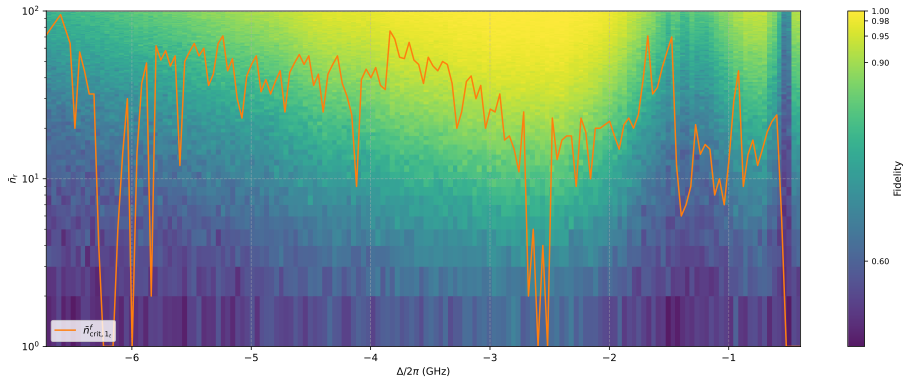

In [91]:
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.ticker as mticker

# Set the global color limits (based on fidelity grid)
vmin = fidelity_grid_sorted.min()
vmax = fidelity_grid_sorted.max()

# Colormap and logarithmic normalization
cmap = plt.get_cmap('viridis')
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)  # log scale for colors

fig, axs = plt.subplots(1, 1, figsize=(14, 5.5))

axs.set_xlabel(r'$\Delta/2\pi$ (GHz)')
axs.set_ylabel(r'$\bar{n}_\text{r}$')
axs.grid(True, linestyle='--', alpha=0.5)
axs.set_yscale("log")

axs.plot(result_min_loaded[:, 1], result_min_loaded[:, 0],
         label=r"$\bar{n}_{{\rm crit}, 1_t}^f$",
         c="C1",
         )

# Just the imshow
im = axs.imshow(
    fidelity_grid_sorted,
    extent=(delta_for_background.min(), delta_for_background.max(),
            n_r_for_background.min(), n_r_for_background.max()),
    origin='lower', aspect='auto', alpha=0.9,
    cmap=cmap, norm=norm
)

# Colorbar with custom ticks
cbar = fig.colorbar(im, ax=axs)
cbar.set_label(r"Fidelity")

tick_values = [0.6, 0.9, 0.95, 0.98, 1.0]

# Fix the tick positions and labels (no autos!)
cbar.set_ticks(tick_values)
cbar.ax.yaxis.set_major_locator(mticker.FixedLocator(tick_values))
cbar.ax.yaxis.set_major_formatter(mticker.FixedFormatter([f"{v:.2f}" for v in tick_values]))

# Kill minor ticks/labels that add scientific notation
cbar.minorticks_off()
cbar.ax.yaxis.set_minor_locator(mticker.NullLocator())
cbar.ax.yaxis.set_minor_formatter(mticker.NullFormatter())

# Make the label sizes consistent
cbar.ax.tick_params(which='both', labelsize=8)

plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig(os.path.join(images_dir_path, f"detuning_nc_with_ng_{time_string}_exp.png"))

plt.show()
